# EDA on Netflix Content

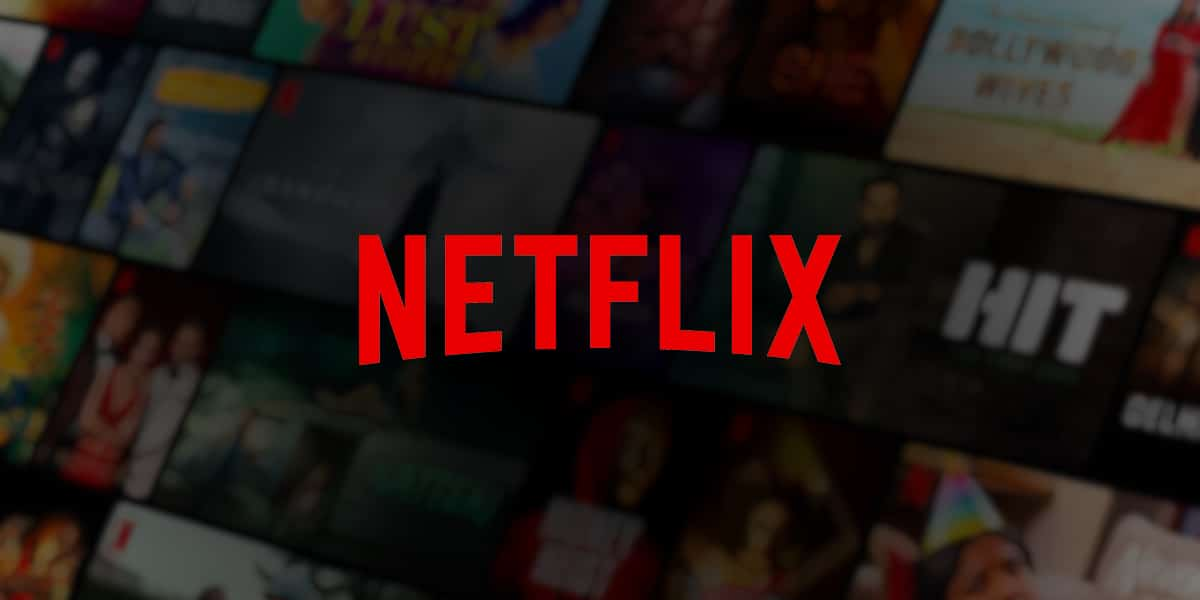

## Table of Contents

1. Introduction
2. Import Libraries
3. Data Preparation and Cleaning
4. Exploratory Analysis and Visualization
5. Conclusions

# 1. Introduction

Thanks to the rise of streaming services, the way people consume entertainment has changed dramatically in recent years. Netflix is undeniably the biggest leader in the streaming world with a total global subscriber count of 232.5 million. 

I want to investigate the trends of the content that Netflix adds to their catalog. What has been the trend in Netflix streaming in recent years? What type of content is popular on Netflix? What country is the biggest contributor of Netflix contents?

In this project, I will explore the Netflix dataset through visualizations and graphs using python libraries, matplotlib, seaborn and plotly. I used Netflix Movies and TV Shows dataset from Kaggle. The dataset consists of listings of all TV Shows and Movies available on Netflix as of mid-2021.

# 2. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

In [2]:
import plotly as py
import plotly.graph_objects as go

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

# 3. Data Preparation and Cleaning

## 3.1 Loading the Dataset

In [5]:
netflix = pd.read_csv(r"C:\Users\eunbi\Desktop\DS\Projects\Netflix titles EDA\netflix_titles.csv")
netflix.shape

(8807, 12)

In [6]:
netflix.nunique()

show_id         8807
type               2
title           8807
director        4528
cast            7692
country          748
date_added      1767
release_year      74
rating            17
duration         220
listed_in        514
description     8775
dtype: int64

I loaded the CSV file using Pandas Library and named the imported dataset as netflix. The dataset contains 8807 different movie/TVshow data: 6126 Movie data and 2664 TV Show data. The columns consist of 12 typical movie/TVshows descriptions, such as type, title, director, cast, country, date added and release year. 


Let's look at the first five data.

In [7]:
netflix.head()

show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 24, 2021          2021  TV-MA   1 Season   
3  September 24, 2021          2021  TV-MA   1 Season   
4  September 24, 2021          2021  TV-MA  2 Seasons   

                                           listed_in  \
0                                      Documentaries   
1    International TV Shows, TV Dramas, TV Mysteries   
2  Crime TV Shows, International TV Shows, TV Act...   
3                             Docuseries, Reality TV   
4  International TV Shows, Romantic TV Shows, TV ...   

                                         description  
0  As her father nears the end of his life, filmm...  
1  After crossing paths at a party, a Cape Town t...  
2  To protect his family from a powerful drug lor...  
3  Feuds, flirtations and toilet talk go down amo...  
4  In a city of coaching centers known to train I...

We can see that there are NaN values in some columns.

## 3.2 Handling missing data
Let's have a look at the missing data.

In [8]:
netflix.isnull().sum().sum()

4307

In [9]:
netflix.isnull().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

Text(0.5, 1.0, 'Visualization of the Nullity of The Data')

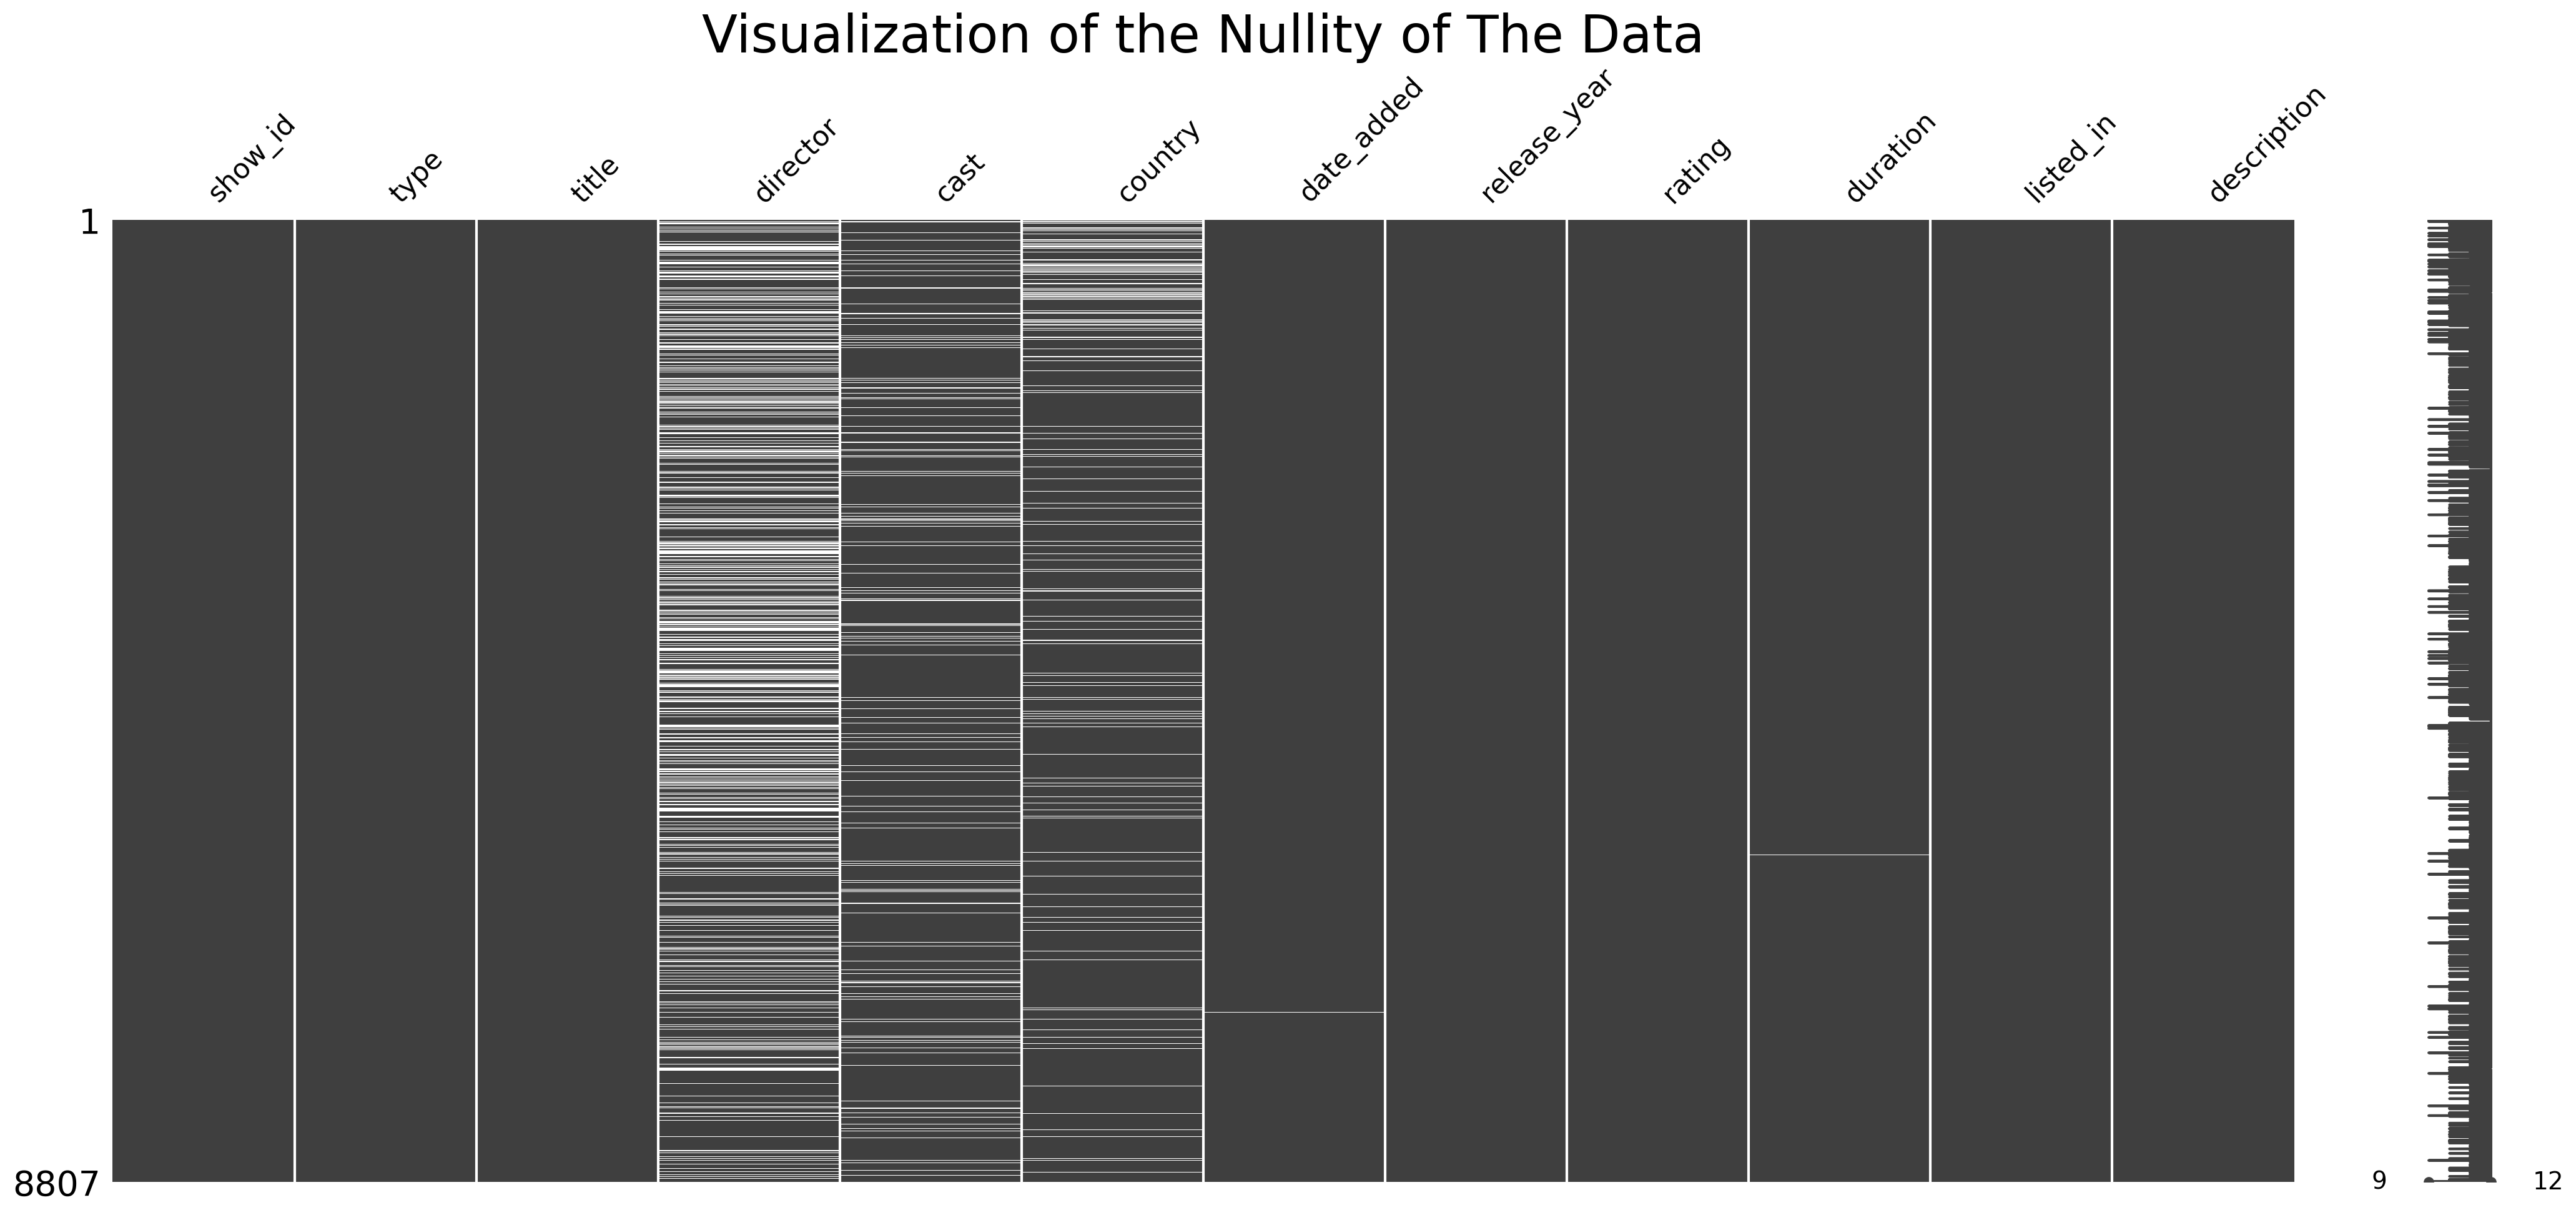

In [10]:
import missingno as msno

msno.matrix(netflix)
plt.title("Visualization of the Nullity of The Data", fontsize=30)

There are a total of 4307 missing values in the data. The visualization above shows that there are a lot of missing values in "director", "cast" and "country" columns. "data_added", "rating" and "duration" also have a few missing values.

The easiest way to get rid of them would be to delete the rows with the missing data. However, this is not the best option for this EDA. Since the number of missing values is large, dropping them would result in a significant loss of information. 

For the columns containing the majority of null values, such as "director", "cast", "country" and "rating", I chose to fill each missing value with 'unavailable' using fillna() function. "date_added", "duration" and "rating" can be dropped from the dataset because they contain an insignificant portion of the data.

In [11]:
netflix["director"] = netflix["director"].fillna("Unavailable")
netflix["cast"] = netflix["cast"].fillna("Unavailable")
netflix["country"] = netflix["country"].fillna("Unavailable")
netflix.dropna(subset=["date_added", "duration", "rating"], inplace=True)

In [12]:
netflix.isnull().sum()

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

In [13]:
netflix.shape

(8790, 12)

Finally, we can see that there are no more missing values in the data. The data size is reduced to 8790.

## 3.3 Dates data
The datatype of "date_added" is object type. Transforming this variable to datetime data will be helpful. I will extract year and month from "date added" and add new columns "year_added" and "month_added".

In [14]:
netflix["date_added"] = pd.to_datetime(netflix["date_added"])
netflix["year_added"] = netflix["date_added"].dt.year
netflix["month_added"] = netflix["date_added"].dt.month
netflix.head(1)

show_id   type                 title         director         cast  \
0      s1  Movie  Dick Johnson Is Dead  Kirsten Johnson  Unavailable   

         country date_added  release_year rating duration      listed_in  \
0  United States 2021-09-25          2020  PG-13   90 min  Documentaries   

                                         description  year_added  month_added  
0  As her father nears the end of his life, filmm...        2021            9

## 3.4 Unnesting columns

Some columns, such as "cast" and "country", contain a list of string values. Unnesting these columns will be possible. First, I want to create separate lines for each cast member in a movie.

In [15]:
# unnesting "cast" columns
constraint=netflix["cast"].apply(lambda x: str(x).split(', ')).tolist()
actors_un = pd.DataFrame(constraint,index=netflix["title"])
actors_un = actors_un.stack()
actors_un = pd.DataFrame(actors_un.reset_index())
actors_un.rename(columns={0:'Actors'},inplace=True)
actors_un.drop(['level_1'],axis=1,inplace=True)
actors_un.head()

title          Actors
0  Dick Johnson Is Dead     Unavailable
1         Blood & Water      Ama Qamata
2         Blood & Water     Khosi Ngema
3         Blood & Water   Gail Mabalane
4         Blood & Water  Thabang Molaba

A lot of contents are listed in multiple genres. I want to create separate lines for each genre as well.

In [16]:
# unnesting "listed_in" columns
constraint2 = netflix["listed_in"].apply(lambda x: str(x).split(', ')).tolist()
genres_un = pd.DataFrame(constraint2,index=netflix["title"])
genres_un = genres_un.stack()
genres_un = pd.DataFrame(genres_un.reset_index())
genres_un.rename(columns={0:"Genre"},inplace=True)
genres_un.drop(["level_1"],axis=1,inplace=True)
genres_un.head()

title                   Genre
0  Dick Johnson Is Dead           Documentaries
1         Blood & Water  International TV Shows
2         Blood & Water               TV Dramas
3         Blood & Water            TV Mysteries
4             Ganglands          Crime TV Shows

Lastly, I'm going to create separate lines for each country in a movie.

In [17]:
# unnesting "country" columns
constraint3 = netflix["country"].apply(lambda x: str(x).split(', ')).tolist()
country_un = pd.DataFrame(constraint3, index=netflix["title"])
country_un = country_un.stack()
country_un = pd.DataFrame(country_un.reset_index())
country_un.rename(columns={0:"Country"}, inplace=True)
country_un.drop(["level_1"], axis=1, inplace=True)
country_un.head()

title        Country
0   Dick Johnson Is Dead  United States
1          Blood & Water   South Africa
2              Ganglands    Unavailable
3  Jailbirds New Orleans    Unavailable
4           Kota Factory          India

In [18]:
# merge unnested actors data with unnested genres data
netflix_un = actors_un.merge(genres_un, on=["title"], how="inner")
# merge the above data with unnested  countries data
netflix_un = netflix_un.merge(country_un, on=["title"], how="inner")
# merge the anove data with the original data 
cols = ["show_id", "director", "type", "title", "date_added", "year_added", "month_added", "release_year", "rating", "duration"]
netflix_new = netflix_un.merge(netflix[cols], on=["title"], how="left")
netflix_new.head()

title       Actors                   Genre        Country  \
0  Dick Johnson Is Dead  Unavailable           Documentaries  United States   
1         Blood & Water   Ama Qamata  International TV Shows   South Africa   
2         Blood & Water   Ama Qamata               TV Dramas   South Africa   
3         Blood & Water   Ama Qamata            TV Mysteries   South Africa   
4         Blood & Water  Khosi Ngema  International TV Shows   South Africa   

  show_id         director     type date_added  year_added  month_added  \
0      s1  Kirsten Johnson    Movie 2021-09-25        2021            9   
1      s2      Unavailable  TV Show 2021-09-24        2021            9   
2      s2      Unavailable  TV Show 2021-09-24        2021            9   
3      s2      Unavailable  TV Show 2021-09-24        2021            9   
4      s2      Unavailable  TV Show 2021-09-24        2021            9   

   release_year rating   duration  
0          2020  PG-13     90 min  
1          2021  TV-MA  2 Seasons  
2          2021  TV-MA  2 Seasons  
3          2021  TV-MA  2 Seasons  
4          2021  TV-MA  2 Seasons

## 3.5 New column

I want to add a new column about targeting age of contents based on ratings.

In [19]:
netflix_new['target_age'] = ''

netflix_new.loc[netflix_new['rating']=='TV-Y', 'target_age'] = 'Kids'
netflix_new.loc[netflix_new['rating']=='G', 'target_age'] = 'Kids'
netflix_new.loc[netflix_new['rating']=='TV-G', 'target_age'] = 'Kids'

netflix_new.loc[netflix_new['rating']=='TV-Y7', 'target_age'] = 'Older Kids'
netflix_new.loc[netflix_new['rating']=='TV-Y7-FV', 'target_age'] = 'Older Kids'
netflix_new.loc[netflix_new['rating']=='TV-PG', 'target_age'] = 'Older Kids'
netflix_new.loc[netflix_new['rating']=='PG', 'target_age'] = 'Older Kids'

netflix_new.loc[netflix_new['rating']=='PG-13', 'target_age'] = 'Teens'
netflix_new.loc[netflix_new['rating']=='PG-14', 'target_age'] = 'Teens'
netflix_new.loc[netflix_new['rating']=='TV-14', 'target_age'] = 'Teens'
netflix_new.loc[netflix_new['rating']=='NC-17', 'target_age'] = 'Teens'

netflix_new.loc[netflix_new['rating']=='R', 'target_age'] = 'Adults'
netflix_new.loc[netflix_new['rating']=='TV-MA', 'target_age'] = 'Adults'

netflix_new.loc[netflix_new['rating']=='NR', 'target_age'] = 'Not rated'
netflix_new.loc[netflix_new['rating']=='UR', 'target_age'] = 'Not rated'

Now, it's finally time to explore the data and create visualizations.

# 4. Visualization

## 4.1 Content Preferences on Netflix: Movies vs. TV Shows

The dataset consists of 6126 movie data and 2664 TV show data. I want to compare them with ratio. Pie chart would be a good choice for the proportions of categorical data.

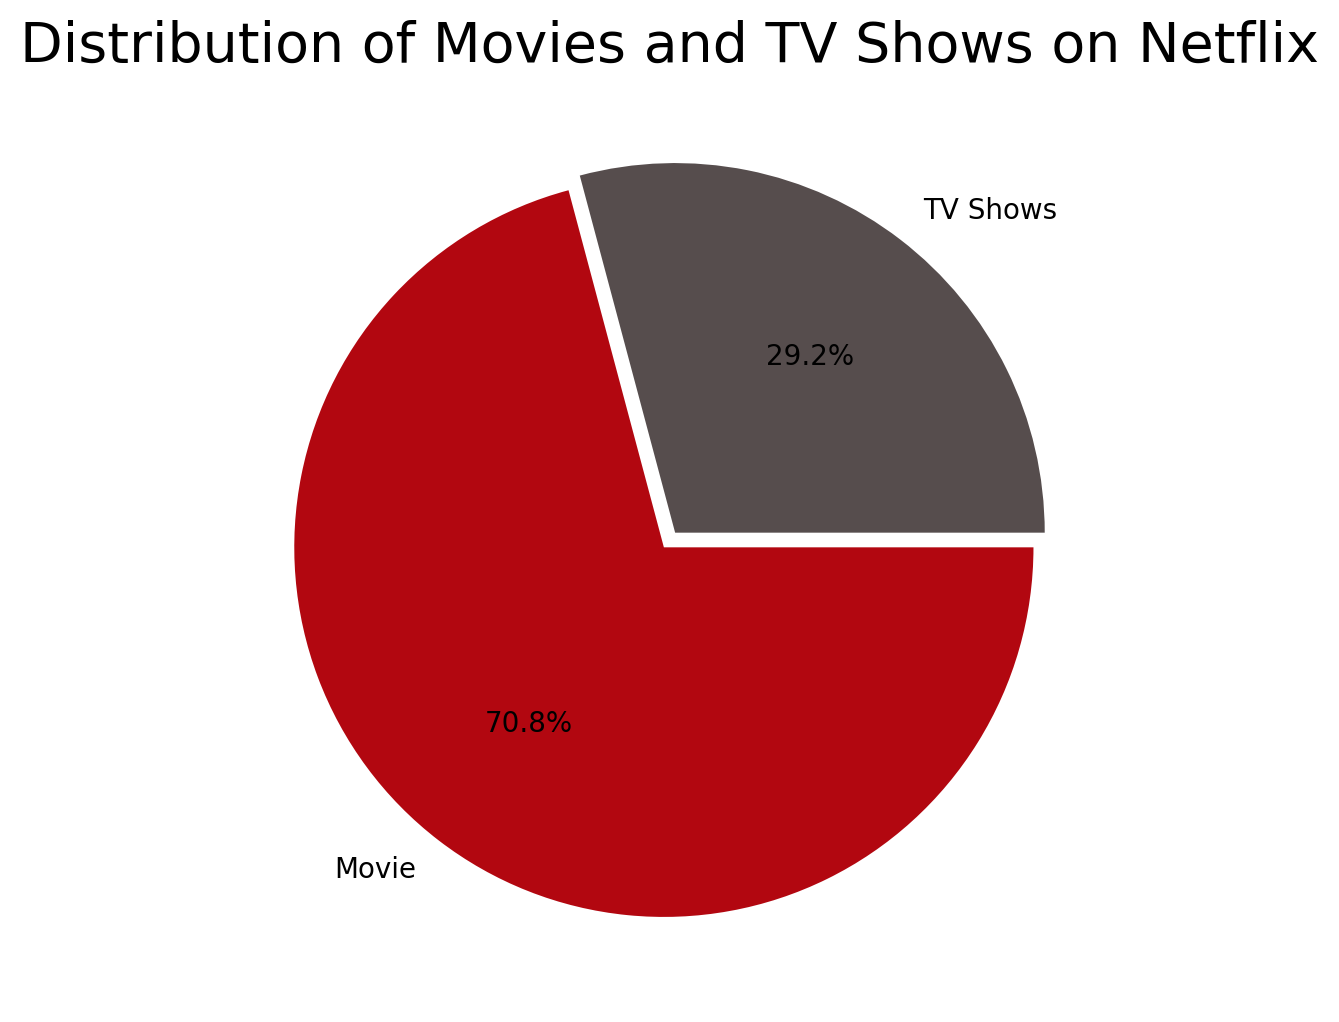

In [20]:
# Calculate the ratio of Movies and TV Shows
label = ["Movie", "TV Shows"]
mtratio = netflix_new["type"].value_counts(normalize=True)
# Draw a pie chart indicating the percentage of Moves and TV Shows
plt.rcParams["figure.figsize"] = (13,6)
plt.pie(mtratio, labels=label, colors=['#B20710', '#564d4d'], counterclock=False, 
        explode=(0.025,0.025), textprops={'fontsize': 10},
        autopct='%.1f%%')
plt.title("Distribution of Movies and TV Shows on Netflix", fontsize=20)
plt.show()

There are more than 6000 movies and almost 3,000 TV shows on Netflix, with movies being the majority. There are far more movie titles (69.7%) than TV shows titles (30.3%).

## 4.2 Movies and TV Shows added over time
Now, I will explore the amount of content Netflix has added over the previous years. I will extract year and month from "date added" and add new columns "year_added" and "month_added". 

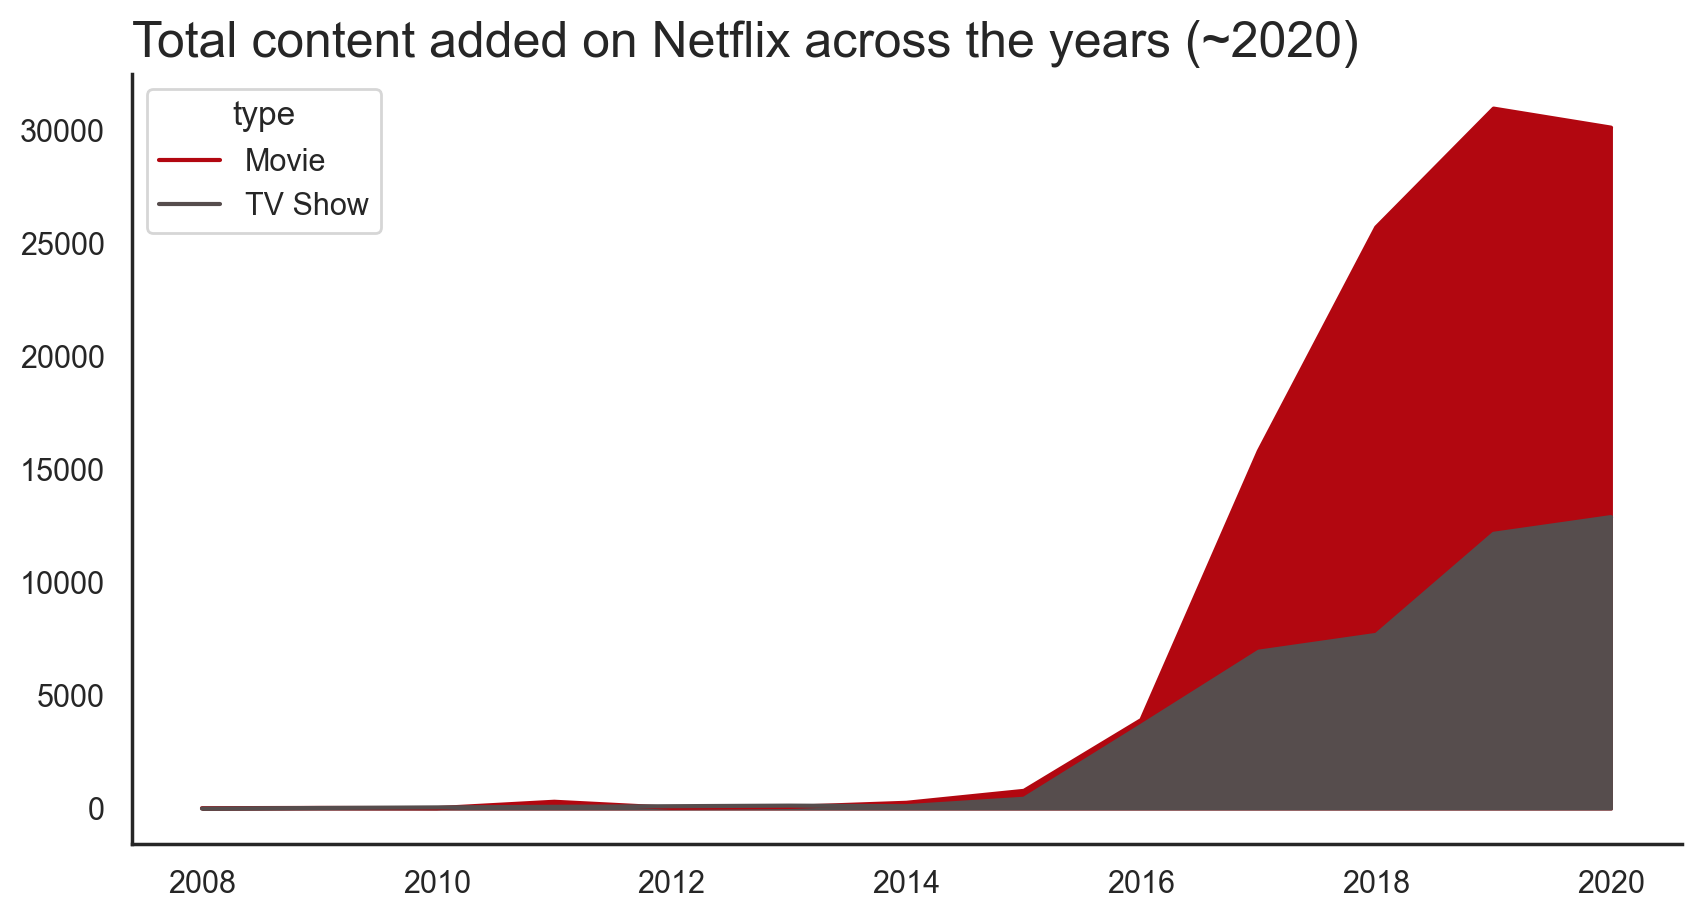

In [21]:
by_type = netflix_new.groupby(['year_added', 'type'])['title'].count().reset_index()
by_type = by_type[by_type['year_added'] != 2021]
sns.set(rc = {'figure.figsize':(10, 5)})
sns.set_style("white")
sns.lineplot(by_type, x = 'year_added', y = 'title', hue = 'type', 
             color = 'type', palette=['#B20710', '#564d4d'])
plt.title('Total content added on Netflix across the years (~2020)', fontsize = 18, loc='left')
plt.xlabel('')
plt.ylabel('')
plt.fill_between(by_type.loc[by_type['type']=='Movie', 'year_added'].values, by_type.loc[by_type['type']=='Movie', 
                                                                                         'title'].values, color = '#B20710')
plt.fill_between(by_type.loc[by_type['type']=='TV Show', 'year_added'].values, by_type.loc[by_type['type']=='TV Show', 
                                                                                           'title'].values, color = '#564d4d')
sns.despine()
plt.show()

Based on the plot above, we can say that Netflix started growing its business as a streaming platform from 2013. Since 2015, the amount of content added has been rapidly increasing. Besides, it clearly appears that Netflix has increasingly focused on TV shows rather than movies in recent years. While the number of TV show releases kept increasing, the amount of increase in the number of movie releases has reduced since 2017 and the number even dropped in 2020.

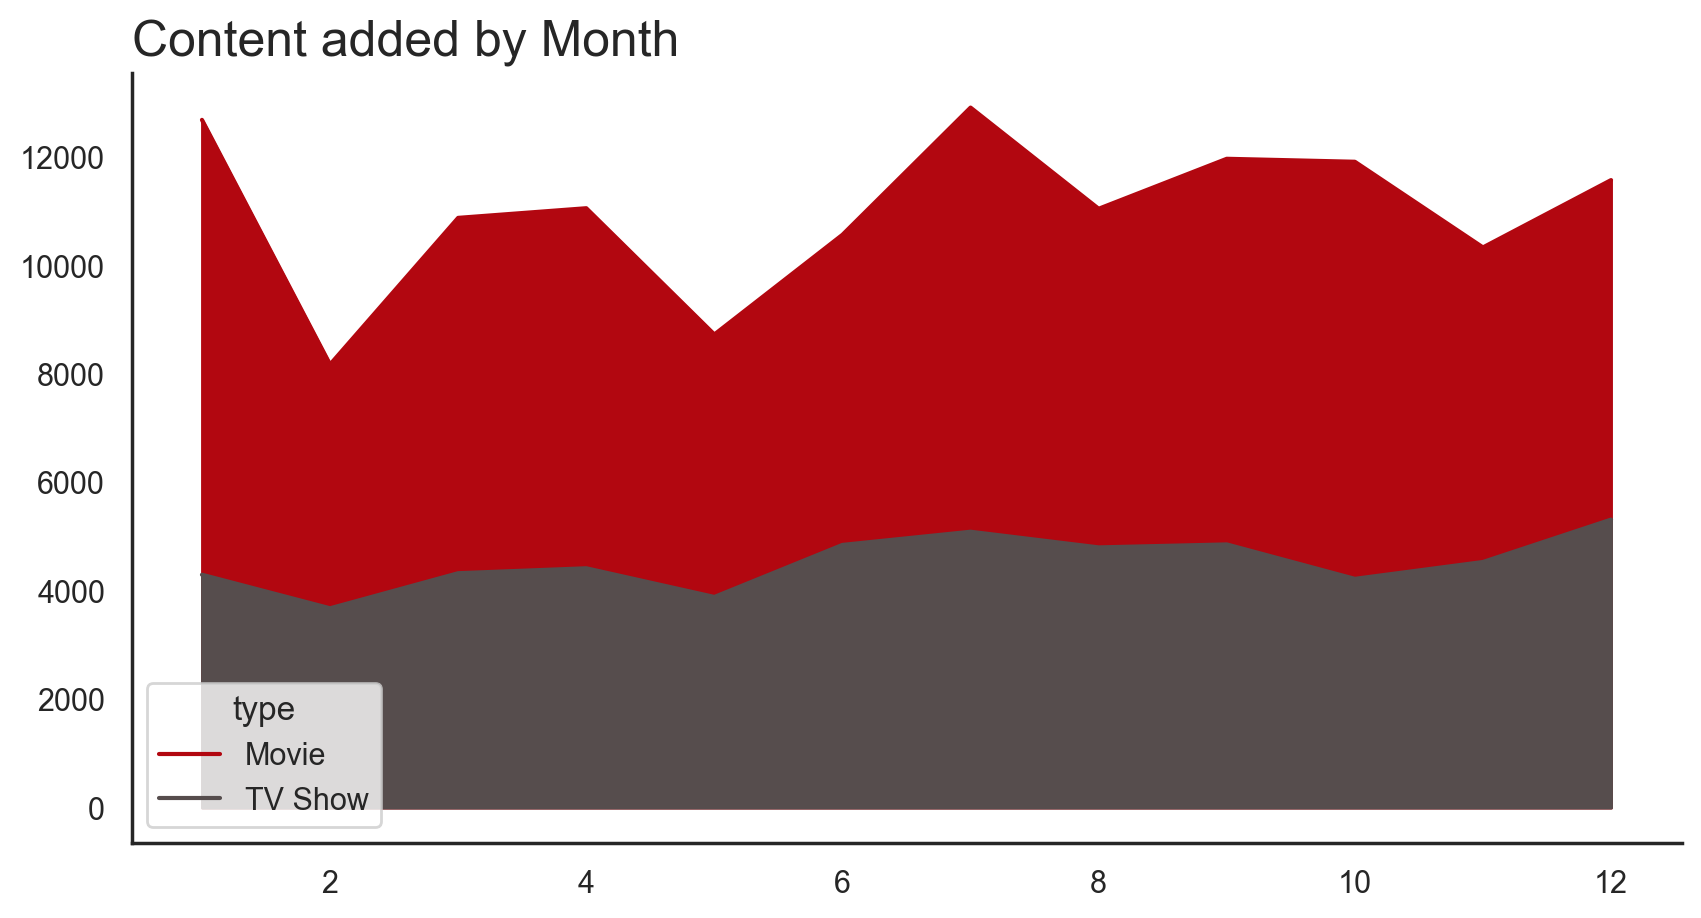

In [22]:
month = netflix_new.groupby(['month_added', 'type'])['title'].count().reset_index()
sns.lineplot(month, x = 'month_added', y = 'title', hue = 'type', 
             color = 'type', palette=['#B20710', '#564d4d'])
plt.title('Content added by Month', fontsize = 18, loc = 'left')
plt.xlabel('')
plt.ylabel('')
plt.fill_between(month.loc[month['type']=='Movie', 'month_added'].values, month.loc[month['type']=='Movie', 
                                                                                         'title'].values, color = '#B20710')
plt.fill_between(month.loc[month['type']=='TV Show', 'month_added'].values, month.loc[month['type']=='TV Show', 
                                                                                           'title'].values, color = '#564d4d')
sns.despine()
plt.show()

Holiday seasons — December, January, and July seem to be the best time for the release of new content on Netflix. Netflix acknowledges its customers’ time-spending habits, that they tend to have more time off during those periods of the year. Also noted that Netflix adds more new Movies during the second half of the year, from June to December.

## 4.3 Which country produces the most content on Netflix?

In [23]:
# path to geojson file
geo_path = r"C:\Users\eunbi\Desktop\DS\countries.geo.json"

import json
geo_json = json.load(open(geo_path, encoding="utf-8"))

In [24]:
# min year in your dataset
netflix_new['year_added'] = netflix_new['year_added'].astype('object')
count = netflix_new.groupby(['year_added','Country'])['title'].count().reset_index()
count.loc[count['Country'] == 'United States', 'Country'] = 'United States of America'

# minimum_year
year = 2008
count = count.copy()
data_slider = []
for year in count['year_added'].unique():
    df_segmented =  count.loc[(count['year_added']== year)]

    for col in df_segmented.columns:
        df_segmented[col] = df_segmented[col].astype(str)

    data_each_yr = dict(
                        type='choropleth',
                        locations = df_segmented['Country'],
                        z=df_segmented['title'].astype(float),
                        locationmode='country names',
                        colorscale = 'reds',
                        colorbar= {'title':'# titles'})

    data_slider.append(data_each_yr)

steps = []
for i in range(len(data_slider)):
    step = dict(method='restyle',
                args=['visible', [False] * len(data_slider)],
                label='Year {}'.format(i + 2008))
    step['args'][1][i] = True
    steps.append(step)

sliders = [dict(active=0, pad={"t": 1}, steps=steps)]

layout = dict(title ='Netflix titles by Country (~2020)', geo=dict(scope='world'),
              sliders=sliders)

fig = dict(data=data_slider, layout=layout)
py.offline.iplot(fig)

It was 2010 when Netflix began expanding their markets internationally to Canada, which is geographically close and shares many cultural similarities with the United States. In 2016, Netflix began its worldwide expansion.

Text(0.5, 0, '')

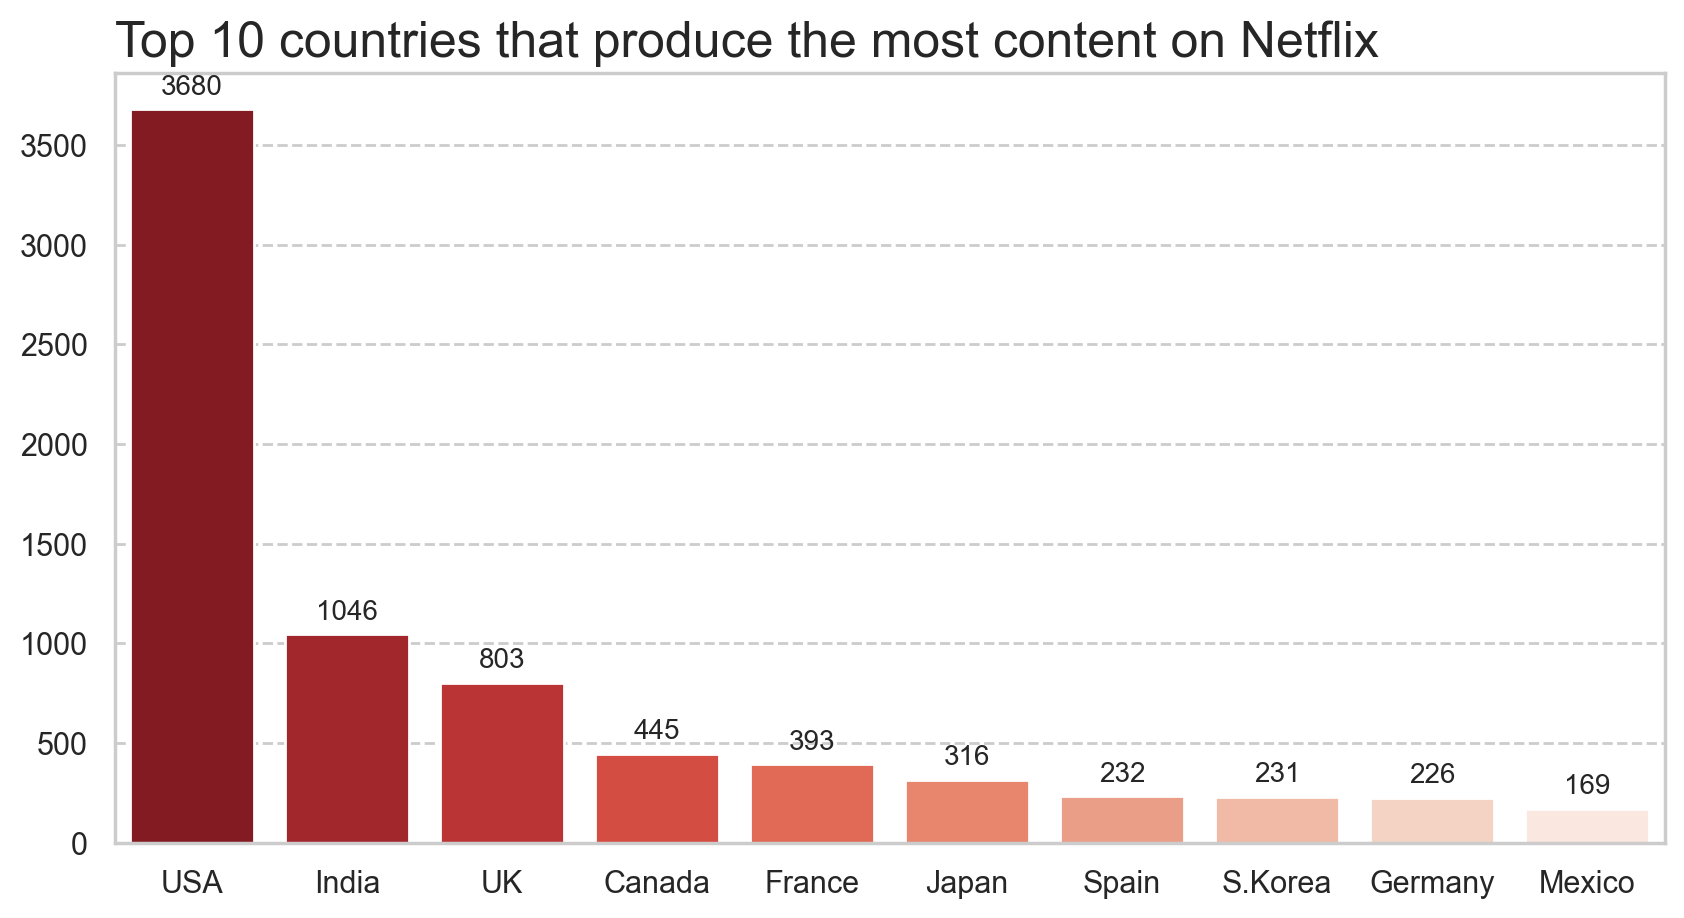

In [25]:
# Top 10 countries
netflix_new.loc[netflix_new['Country'] == 'United States', 'Country'] = 'USA'
netflix_new.loc[netflix_new['Country'] == 'United Kingdom', 'Country'] = 'UK'
netflix_new.loc[netflix_new['Country'] == 'South Korea', 'Country'] = 'S.Korea'
country_filtered = netflix_new.loc[netflix_new["Country"]!= "Unavailable",]
countries = country_filtered.groupby(["Country"])["title"].nunique().reset_index()
countries = countries.sort_values(by="title", ascending=False).reset_index()
countries = countries.drop("index", axis=1)
# Draw a barplot
sns.set_theme(rc={'figure.figsize':(10, 5)})
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt = sns.barplot(countries.head(10), y="title", x="Country", palette="Reds_r")
for bar in plt.patches:
  plt.annotate(format(bar.get_height(), '.0f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
plt.set_title("Top 10 countries that produce the most content on Netflix", fontsize = 18, loc='left')
plt.set_ylabel("")
plt.set_xlabel("")

Netflix offers internationally diverse content. The majority of Netflix contents obviously come from United States. Although India and the U.K. rank second and third among Netflix content producers, they have a significant distance behind the U.S.

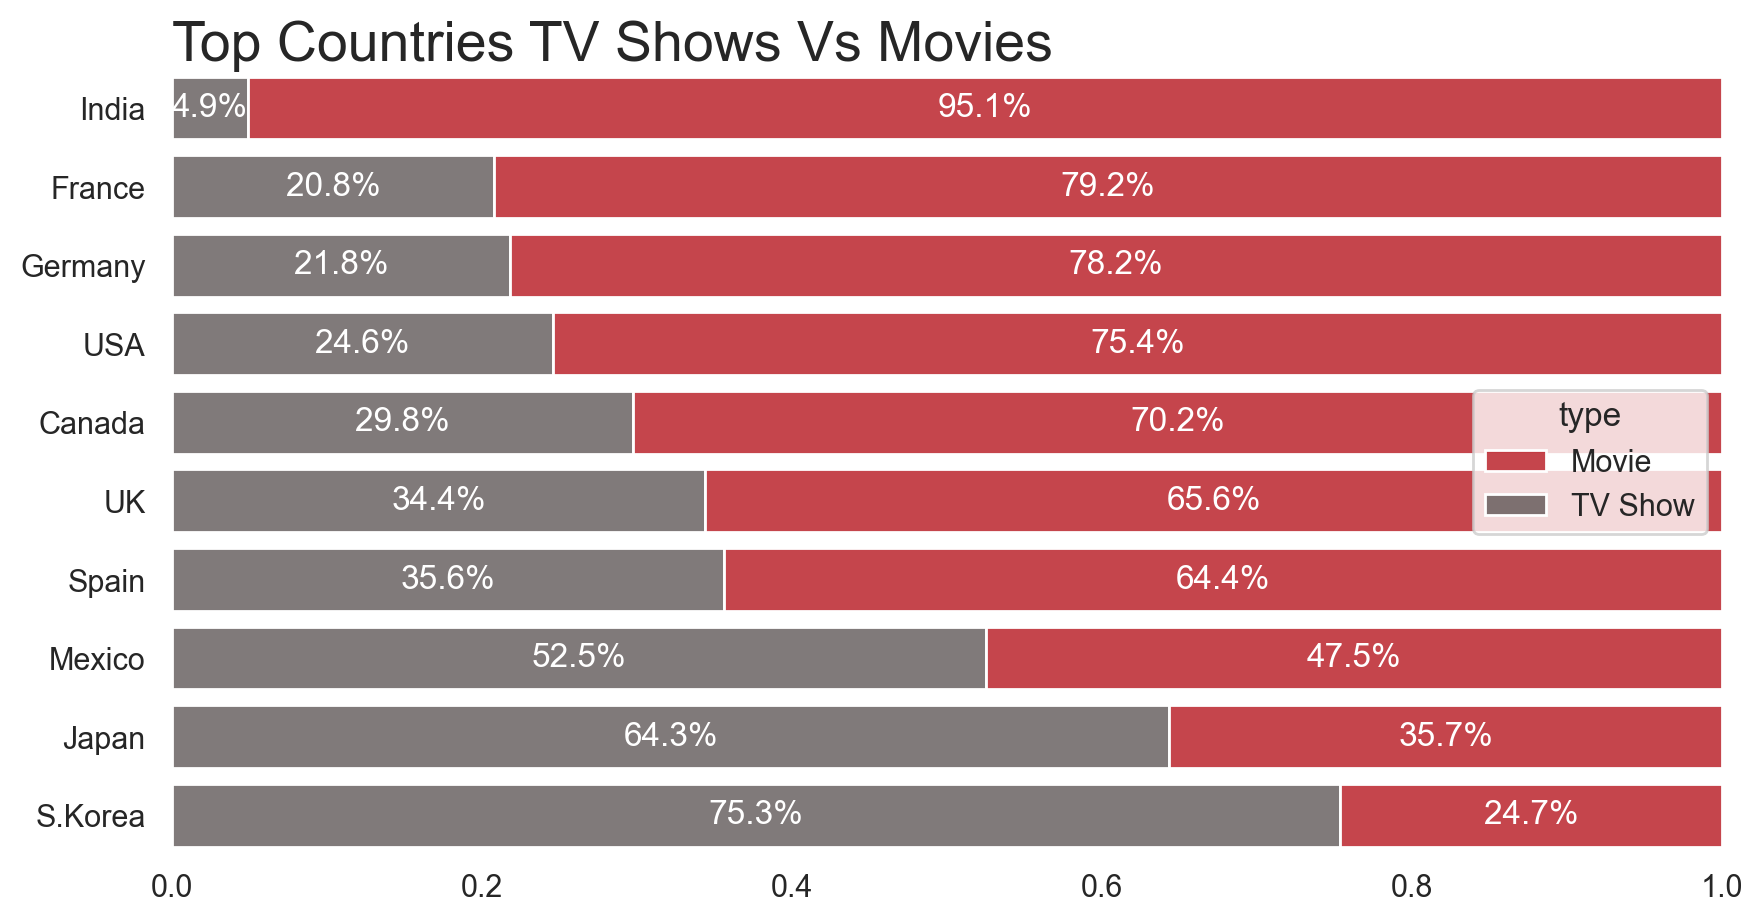

In [26]:
netflix_new['type'] = netflix_new['type'].astype('category')
countries_list = countries.head(10).Country.values.tolist()
df = netflix_new[netflix_new['Country'].isin(countries_list)]
df = df.groupby(['Country', 'type'])['title'].count().reset_index()
df = df.pivot_table(values='title', index = 'Country', columns = 'type', aggfunc='first').reset_index()
countries_list = countries.head(10).Country.values.tolist()
filtered = netflix_new[netflix_new['Country'].isin(countries_list)]
filtered.Country = filtered.Country.astype('category')
filtered['Country'] = pd.Categorical(filtered['Country'], ['India','France','Germany','USA', 'Canada', 'UK', 
                                                       'Spain', 'Mexico', 'Japan', 'S.Korea'])
sns.set_theme(rc={'figure.figsize':(10, 5)})
sns.set_theme(style="white")
plt = sns.histplot(data = filtered, y = 'Country', hue = 'type',
            multiple = 'fill', stat = 'proportion', discrete = True, palette=['#B20710', '#564d4d'], shrink = 0.8)
for bars in plt.containers:
    heights = [b.get_width() for b in bars]
    labels = [f'{h * 100:.1f}%' if h > 0.001 else '' for h in heights]
    plt.bar_label(bars, labels=labels, label_type='center', color = 'white')
plt.set_title('Top Countries TV Shows Vs Movies', fontsize = 20, loc='left')
plt.set_ylabel('')
plt.set_xlabel('')
sns.despine(left = True, bottom = True)

Bollywood and Hollywood, 2 big film industries in the world, have the number of Movies on Netflix outweighs the number of TV Shows. Whereas, the gap between Movies and TV Shows from Mexico is smaller, which means the preference between Movie content and TV Show content from Mexico is more balanced. On the other hand, Netflix seems to invest more in TV series from East Asian countries — Japan and South Korea, while it invests more in Movies from European countries — France, Germany, the U.k. and Spain.

## 4.4 Ratings and Target audience

In [27]:
import matplotlib
import matplotlib.pyplot as plt

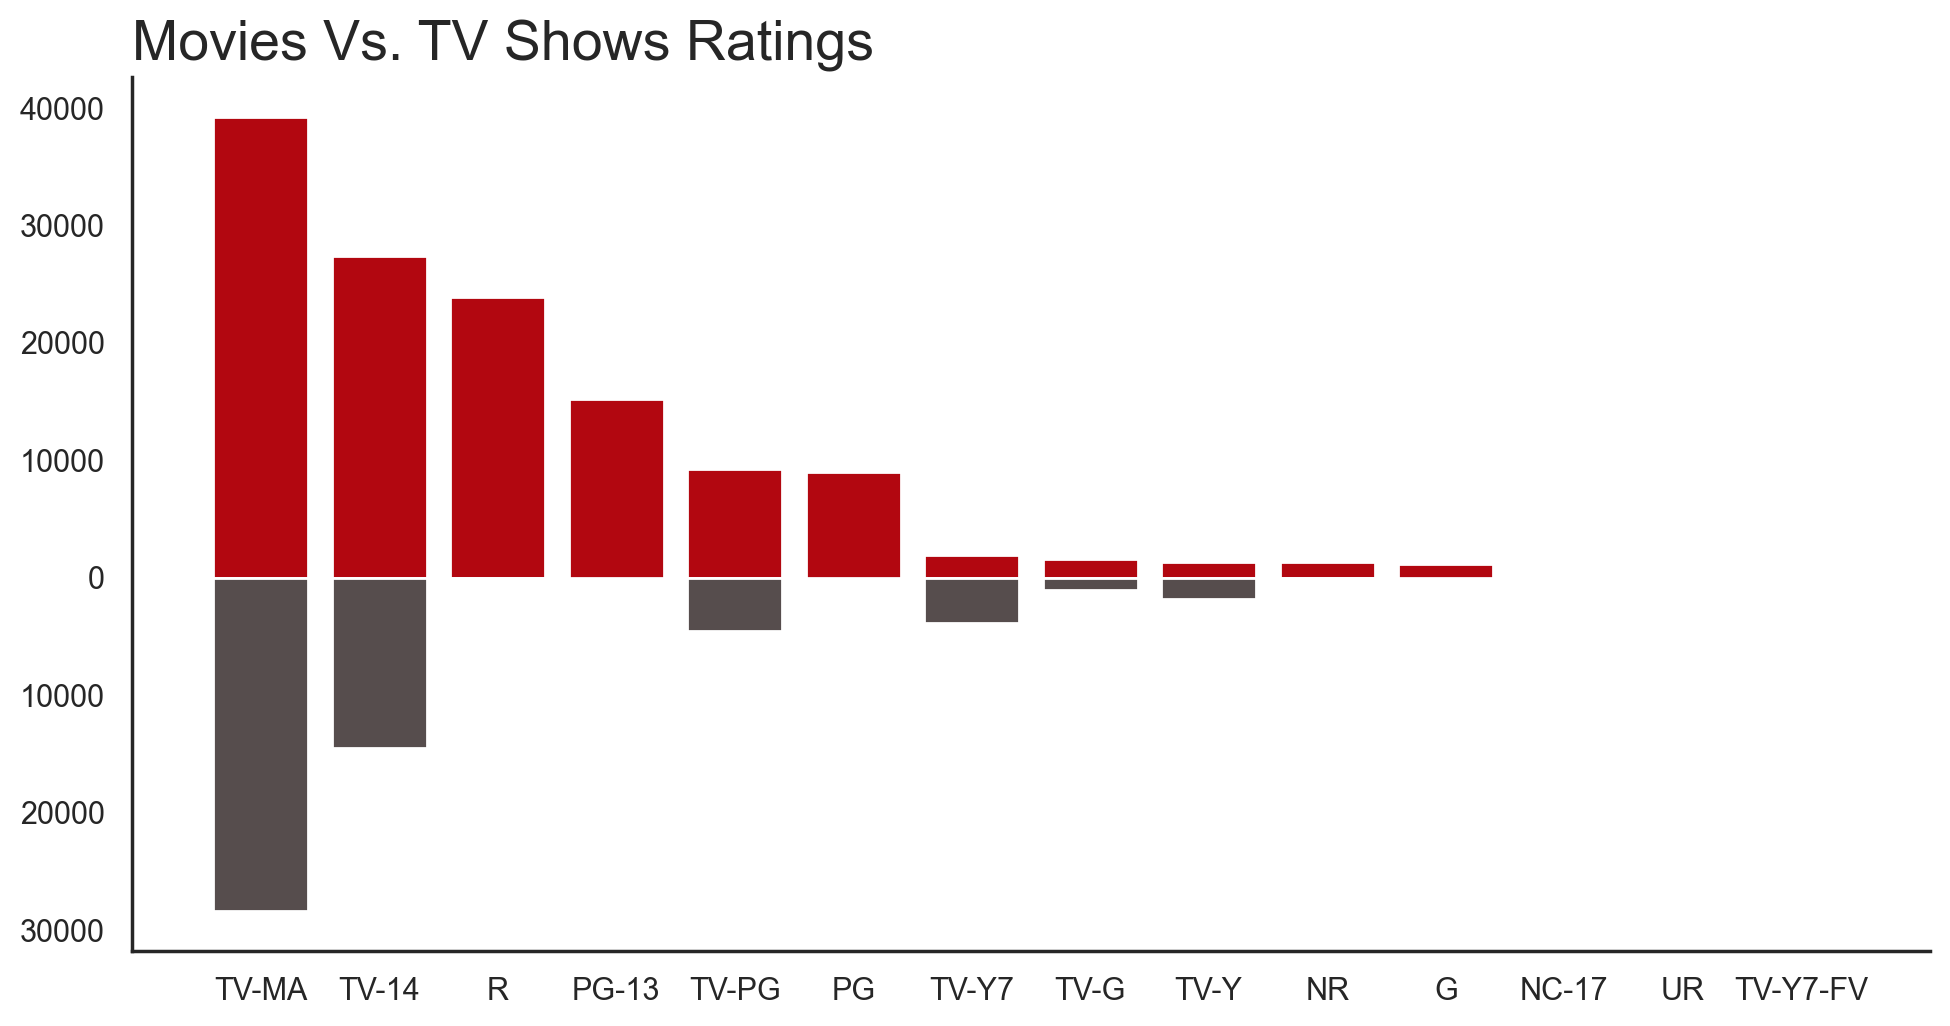

In [28]:
ratings_m = netflix_new[netflix_new['type']=='Movie'].groupby(['rating'])['title'].count().reset_index()
ratings_m = ratings_m.sort_values('title', ascending = False)
ratings_t = netflix_new[netflix_new['type']=='TV Show'].groupby(['rating'])['title'].count().reset_index()
ratings_t['title'] = ratings_t['title'] * (-1)

fig, ax = plt.subplots(figsize = (10, 5))
ax.bar(ratings_m['rating'], ratings_m['title'], color = '#B20710')
ax.bar(ratings_t['rating'], ratings_t['title'], color = '#564d4d')

# Formatting x labels
plt.tight_layout()
# Use absolute value for y-ticks
ticks =  ax.get_yticks()
ax.set_yticklabels([int(abs(tick)) for tick in ticks])
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_title('Movies Vs. TV Shows Ratings', fontsize = 20, loc='left')
plt.show()

Some ratings, such as PG-13, PG, NC-17 and UR, are only applicable to Movies. The most common rating for both Movie and TV Show is TV-MA (for adult groups) and TV-14 (for teen groups).

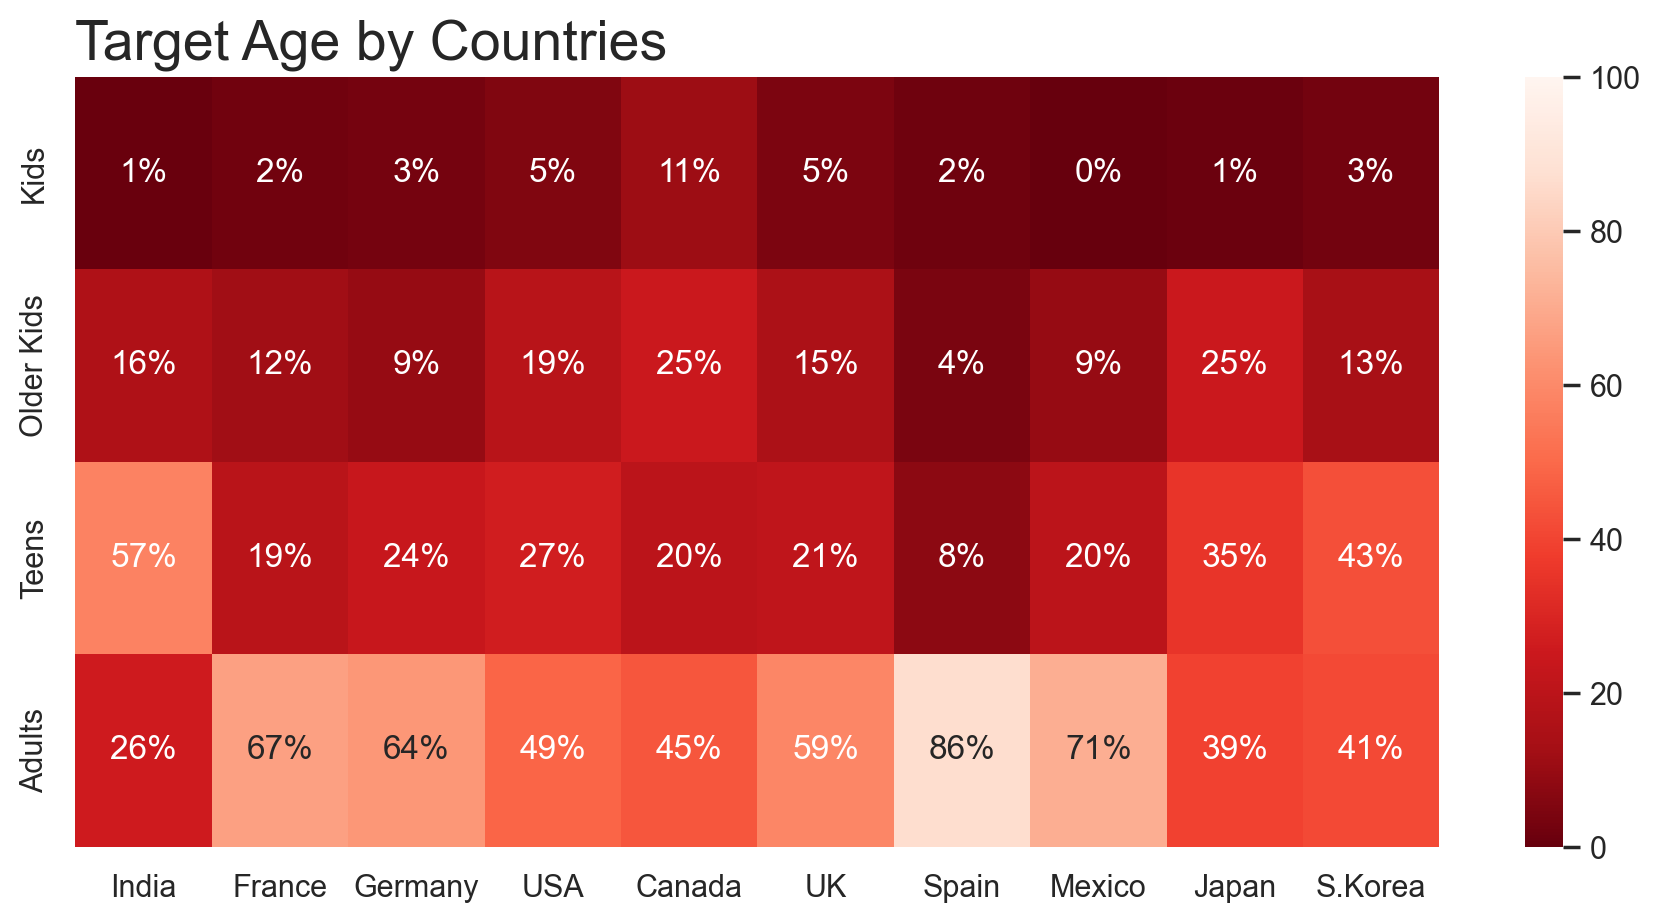

In [29]:
age_agg = filtered[filtered['target_age']!='Not rated'].groupby(['Country', 'target_age']).agg({'title': 'count'})
age_agg = age_agg.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))
age_agg.reset_index(inplace = True)
age_pivot = age_agg.pivot(index='target_age', columns = 'Country', values = 'title' )
age_agg.target_age = age_agg.target_age.astype('category')
age_pivot.index = pd.CategoricalIndex(age_pivot.index, categories= ['Kids', 'Older Kids', 'Teens', 'Adults'])
age_pivot.sort_index(level=0, inplace=True)
sns.set(rc = {'figure.figsize':(11, 5)})
hm = sns.heatmap(age_pivot,annot=True, fmt = '.0f', vmin = 0, vmax=100, cmap = 'Reds_r') 
hm.set(ylabel=None, xlabel=None)
hm.set_title("Target Age by Countries", fontsize = 20, loc='left')
for t in hm.texts:
    t.set_text(t.get_text() + "%")

Majority of Netflix content from European countries are made for adult viewers. Movies and shows from the USA and the UK target more on adult, while those produced in India target more on teenager group of audience. The largest groups of target audience are adults and teenagers. On the other hand, east asian countries, such as Japan and South Korea target on both teenager and adult groups in balance. The main libraries on Netflix for older kids are Canada and Japan.

## 4.5 How old are the content on Netflix?

In [30]:
average_year = filtered[filtered['type'] == 'Movie'].groupby(['Country']).agg({'year_added':'mean', 'release_year':'mean'}).reset_index()
average_year['year_gap'] = average_year['year_added'] - average_year['release_year']
average_year = average_year.sort_values('year_gap', ascending = False)
category_array = average_year['Country'].tolist()

fig = go.Figure()

for i in range(0, len(average_year)):
    fig.add_trace(go.Scatter(x = np.linspace(average_year['release_year'][i], average_year['year_added'][i], 1000),
                            y = 1000 * [average_year['Country'][i]],
                            mode = 'markers',
                            marker = {'color': np.linspace(average_year['release_year'][i], average_year['year_added'][i], 1000),
                                      'colorscale': ['#564d4d', '#B20710'],
                                      'size': 2}))
    
fig.add_trace(go.Scatter(x = average_year['release_year'],
                         y = average_year['Country'],
                         marker = dict(color = '#564d4d', size = 14),
                         mode = 'markers',
                         name = 'Release year'))

fig.add_trace(go.Scatter(x = average_year['year_added'],
                         y = average_year['Country'],
                         marker = dict(color = '#B20710', size = 14),
                         mode = 'markers',
                         name = 'Added year'))
    
fig.add_annotation(x = average_year.iloc[-1, average_year.columns.get_loc('release_year')] - 1,
                   y = average_year.iloc[-1, average_year.columns.get_loc('Country')],
                   text = 'Release year',
                   font = {'color': 'black',
                           'size': 15},
                   showarrow = False)

fig.add_annotation(x = average_year.iloc[-1, average_year.columns.get_loc('year_added')] + 1,
                   y = average_year.iloc[-1, average_year.columns.get_loc('Country')],
                   text = 'Year added',
                   font = {'color': '#B20710',
                           'size': 15},
                   showarrow = False)
fig.update_layout(title = 'Average Age of Movies in Top Countries',
                 showlegend = False,
                 template = 'plotly_white')
fig.update_yaxes(categoryorder = 'array', categoryarray = category_array)
fig.show()

The age gap varies by country. For content from South Korea and Spain, Netflix appears to promote new movies released from 2016, on average. For content from the U.S. and U.K., Netflix prefers movies produced during the 2010s and newly released.

In [31]:
average_year = filtered[filtered['type'] == 'TV Show'].groupby(['Country']).agg({'year_added':'mean', 'release_year':'mean'}).reset_index()
average_year['year_gap'] = average_year['year_added'] - average_year['release_year']
average_year = average_year.sort_values('year_gap', ascending = False)
category_array = average_year['Country'].tolist()


fig = go.Figure()

for i in range(0, len(average_year)):
    fig.add_trace(go.Scatter(x = np.linspace(average_year['release_year'][i], average_year['year_added'][i], 1000),
                            y = 1000 * [average_year['Country'][i]],
                            mode = 'markers',
                            marker = {'color': np.linspace(average_year['release_year'][i], average_year['year_added'][i], 1000),
                                      'colorscale': ['black', '#B20710'],
                                      'size': 2}))
    
fig.add_trace(go.Scatter(x = average_year['release_year'],
                         y = average_year['Country'],
                         marker = dict(color = '#564d4d', size = 14),
                         mode = 'markers',
                         name = 'Release year'))

fig.add_trace(go.Scatter(x = average_year['year_added'],
                         y = average_year['Country'],
                         marker = dict(color = '#B20710', size = 14),
                         mode = 'markers',
                         name = 'Added year'))
    
fig.add_annotation(x = average_year.iloc[-1, average_year.columns.get_loc('release_year')] - 1,
                   y = average_year.iloc[-1, average_year.columns.get_loc('Country')],
                   text = 'Release year',
                   font = {'color': '#564d4d',
                           'size': 15},
                   showarrow = False)

fig.add_annotation(x = average_year.iloc[-1, average_year.columns.get_loc('year_added')] + 1,
                   y = average_year.iloc[-1, average_year.columns.get_loc('Country')],
                   text = 'Year added',
                   font = {'color': '#B20710',
                           'size': 15},
                   showarrow = False)
fig.update_layout(title = 'Average Age of TV Shows in Top countries',
                 showlegend = False,
                 template = 'plotly_white')
fig.update_yaxes(categoryorder = 'array', categoryarray = category_array)
fig.show()

The age gap for TV Shows seems to be quite smaller comparted to the one for Movies. This might be probably due to the fact that series are updated and released each year. For content from Germany and Spain, Netflix appears to promote new series released from 2018, on average, while for content from Japan, Netflix invests in older series released before 2015.

## 4.6 What are the most common genres on Netflix?

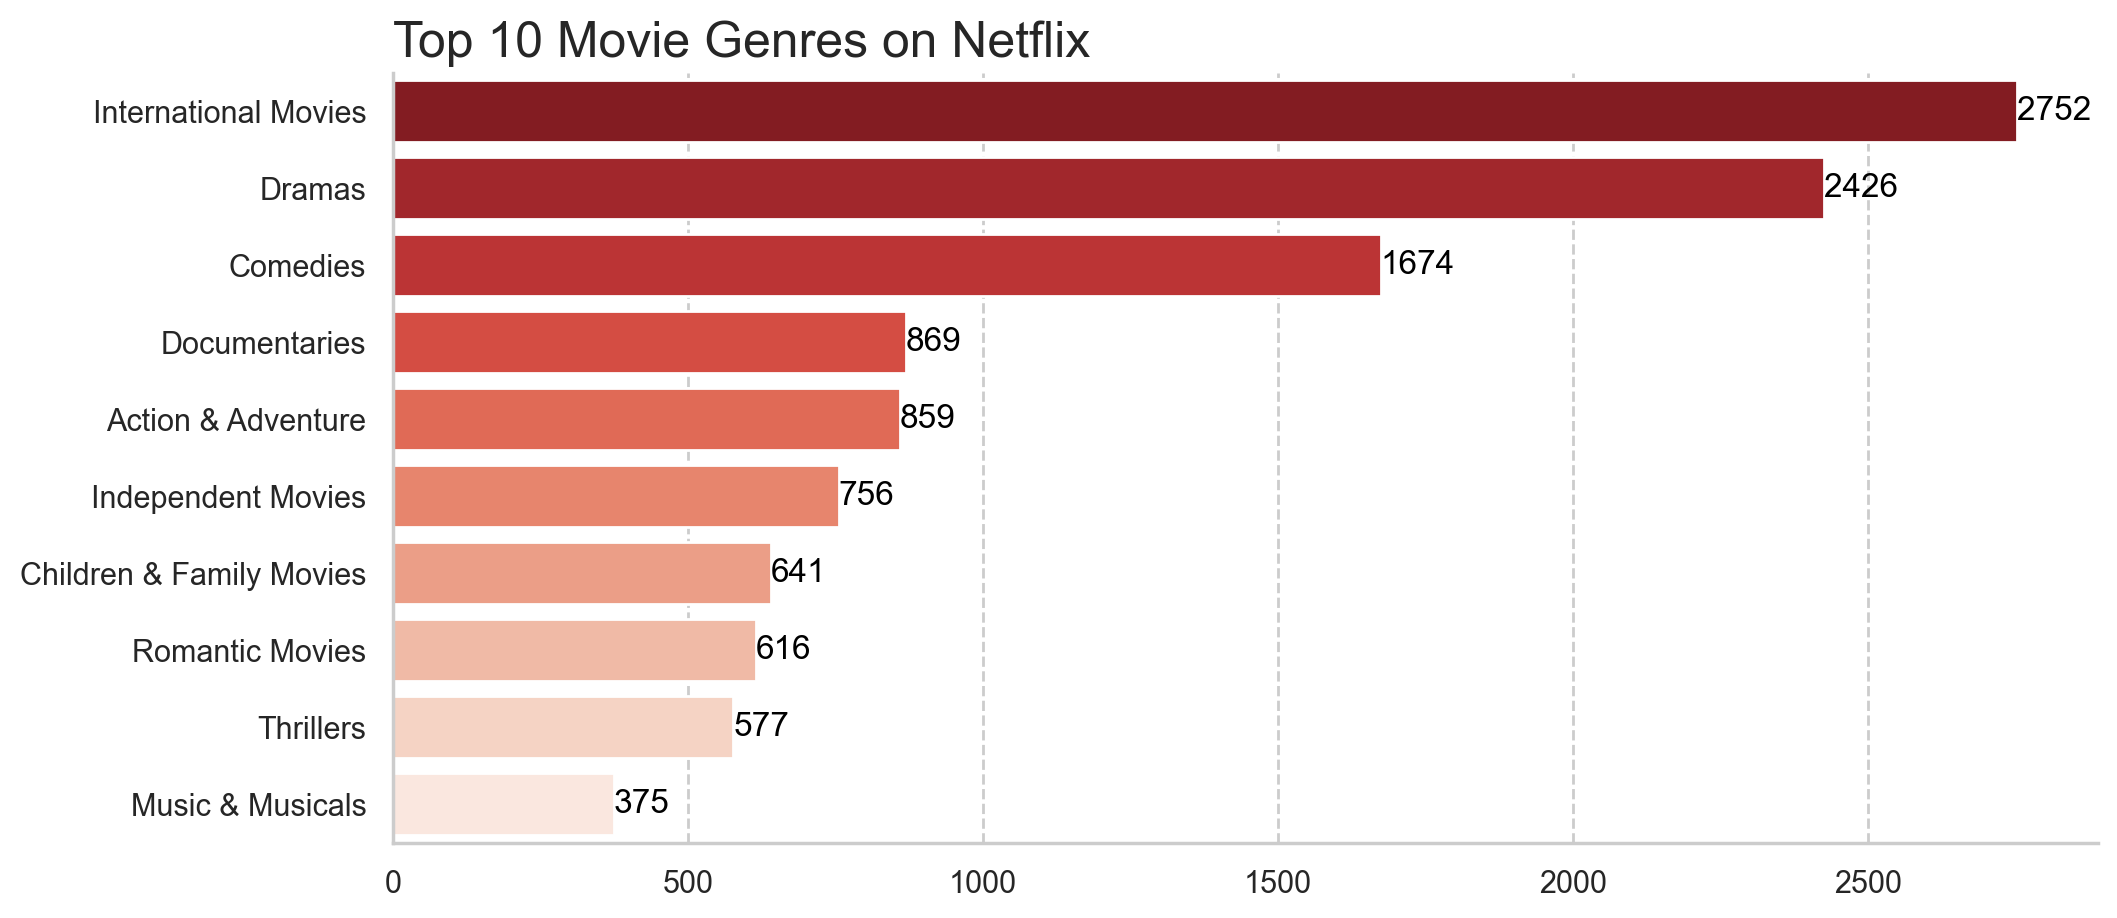

In [32]:
# Top 10 genres
genres = netflix_new[netflix_new['type']=='Movie'].groupby(["Genre"])["title"].nunique().reset_index()
genres = genres.sort_values(by="title", ascending=False).reset_index()
genres = genres.drop("index", axis=1)
# Draw a barplot
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt = sns.barplot(genres.head(10), y="Genre", x="title", palette="Reds_r")
for bars in plt.containers:
    heights = [b.get_width() for b in bars]
    labels = [f'{h:.0f}' if h > 0.001 else '' for h in heights]
    plt.bar_label(bars, labels=labels, label_type='edge', color = 'black')
plt.set_title("Top 10 Movie Genres on Netflix", fontsize = 18, loc='left')
plt.set_ylabel("")
plt.set_xlabel("")
sns.set(rc = {'figure.figsize':(10, 5)})
sns.despine()

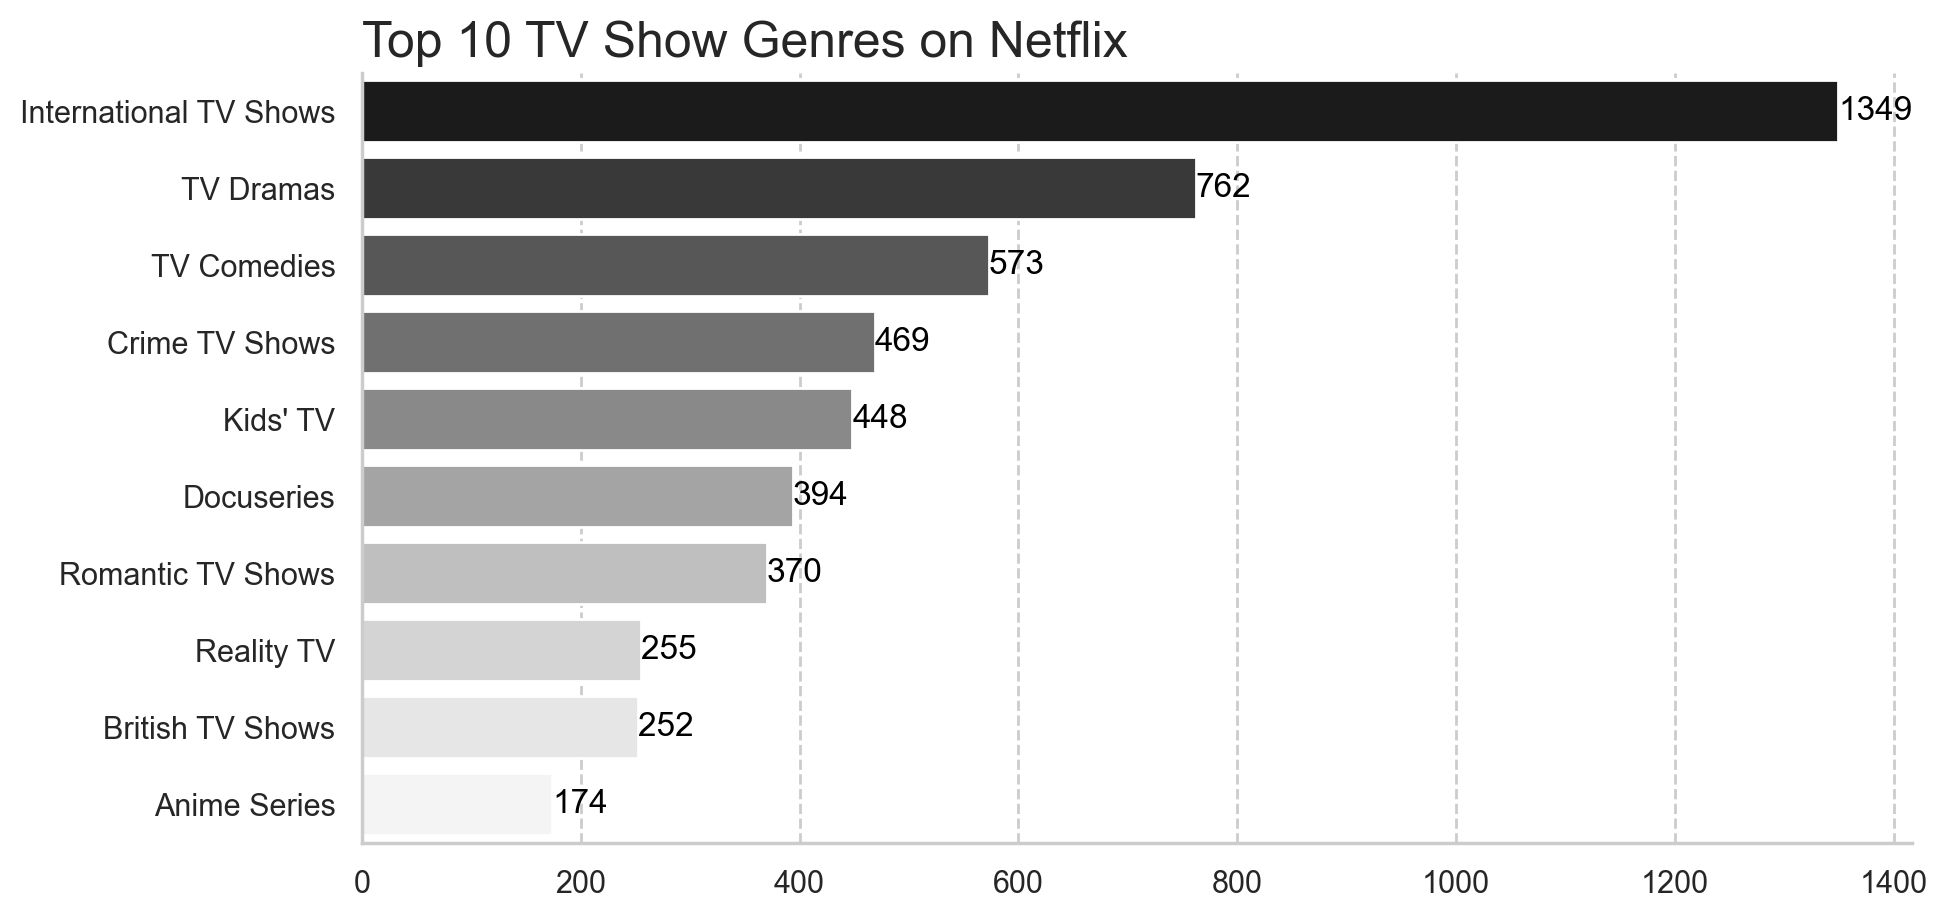

In [33]:
# Top 10 genres
genres = netflix_new[netflix_new['type']=='TV Show'].groupby(["Genre"])["title"].nunique().reset_index()
genres = genres.sort_values(by="title", ascending=False).reset_index()
genres = genres.drop("index", axis=1)
# Draw a barplot
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt = sns.barplot(genres.head(10), y="Genre", x="title", palette="Greys_r")
for bars in plt.containers:
    heights = [b.get_width() for b in bars]
    labels = [f'{h:.0f}' if h > 0.001 else '' for h in heights]
    plt.bar_label(bars, labels=labels, label_type='edge', color = 'black')
plt.set_title("Top 10 TV Show Genres on Netflix", fontsize = 18, loc='left')
plt.set_ylabel("")
plt.set_xlabel("")
sns.set(rc = {'figure.figsize':(10, 5)})
sns.despine()

It's interesting that the top 3 most common genres on Netflix are the same for Movie and TV Show - International, Dramas and Comedies. I am wondering if certain genres of Movie or show are more popular in particular countries.

## 4.7 Most frequent word in Netflix content

### 4.7.1 Netflix Titles

In [52]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
def wordcloud(data, width=1200, height=500):
    word_draw = WordCloud(
        font_path=r"C:\Windows\Fonts\Verdana.ttf",
        stopwords=STOPWORDS,
        width=width, height=height, 
        background_color="white",
        colormap = "Reds_r",
        random_state=42
    )
    word_draw.generate(data)

    plt.figure(figsize=(16, 8))
    plt.imshow(word_draw)
    plt.axis("off")
    plt.show()

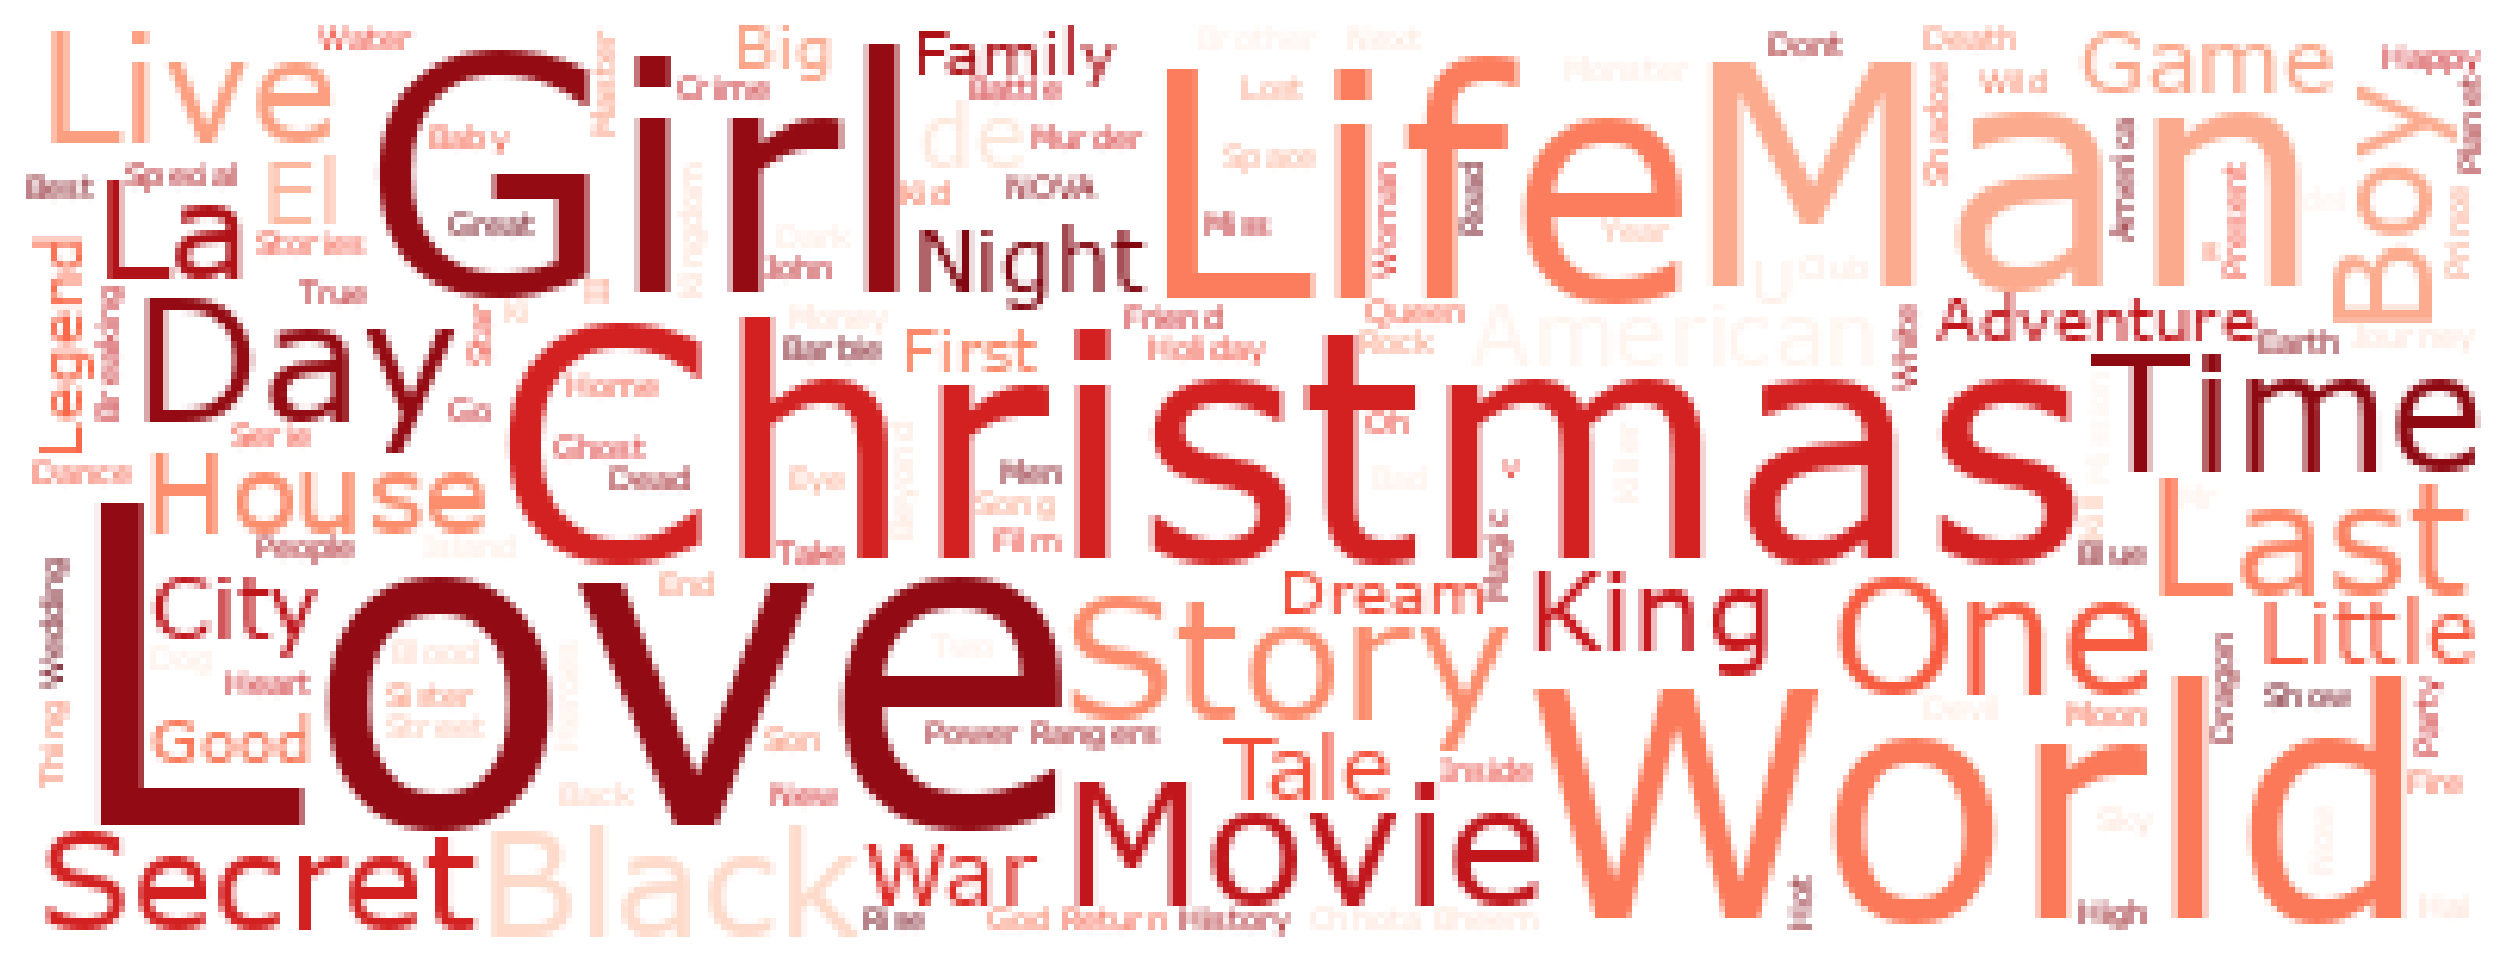

In [53]:
title = netflix["title"].tolist()
title =str(title)
title = re.sub("[\"\-\[\]\'\.\?]", "", title)
title = title.replace(" ", ",")
title = re.sub(",{2,}", ",", title)
wordcloud(title, width=400, height=150)

It is interesting to note that many films and series share the same keywords in their titles and descriptions. This is the word cloud of titles of Netflix content. "Love", "Life" and "Girl" are the most frequent words appearing on Netflix titles. "Story", "World", "Man", "Black" and "Time" also appear more frequently than other words in titles.

### 4.7.2 Netflix Description

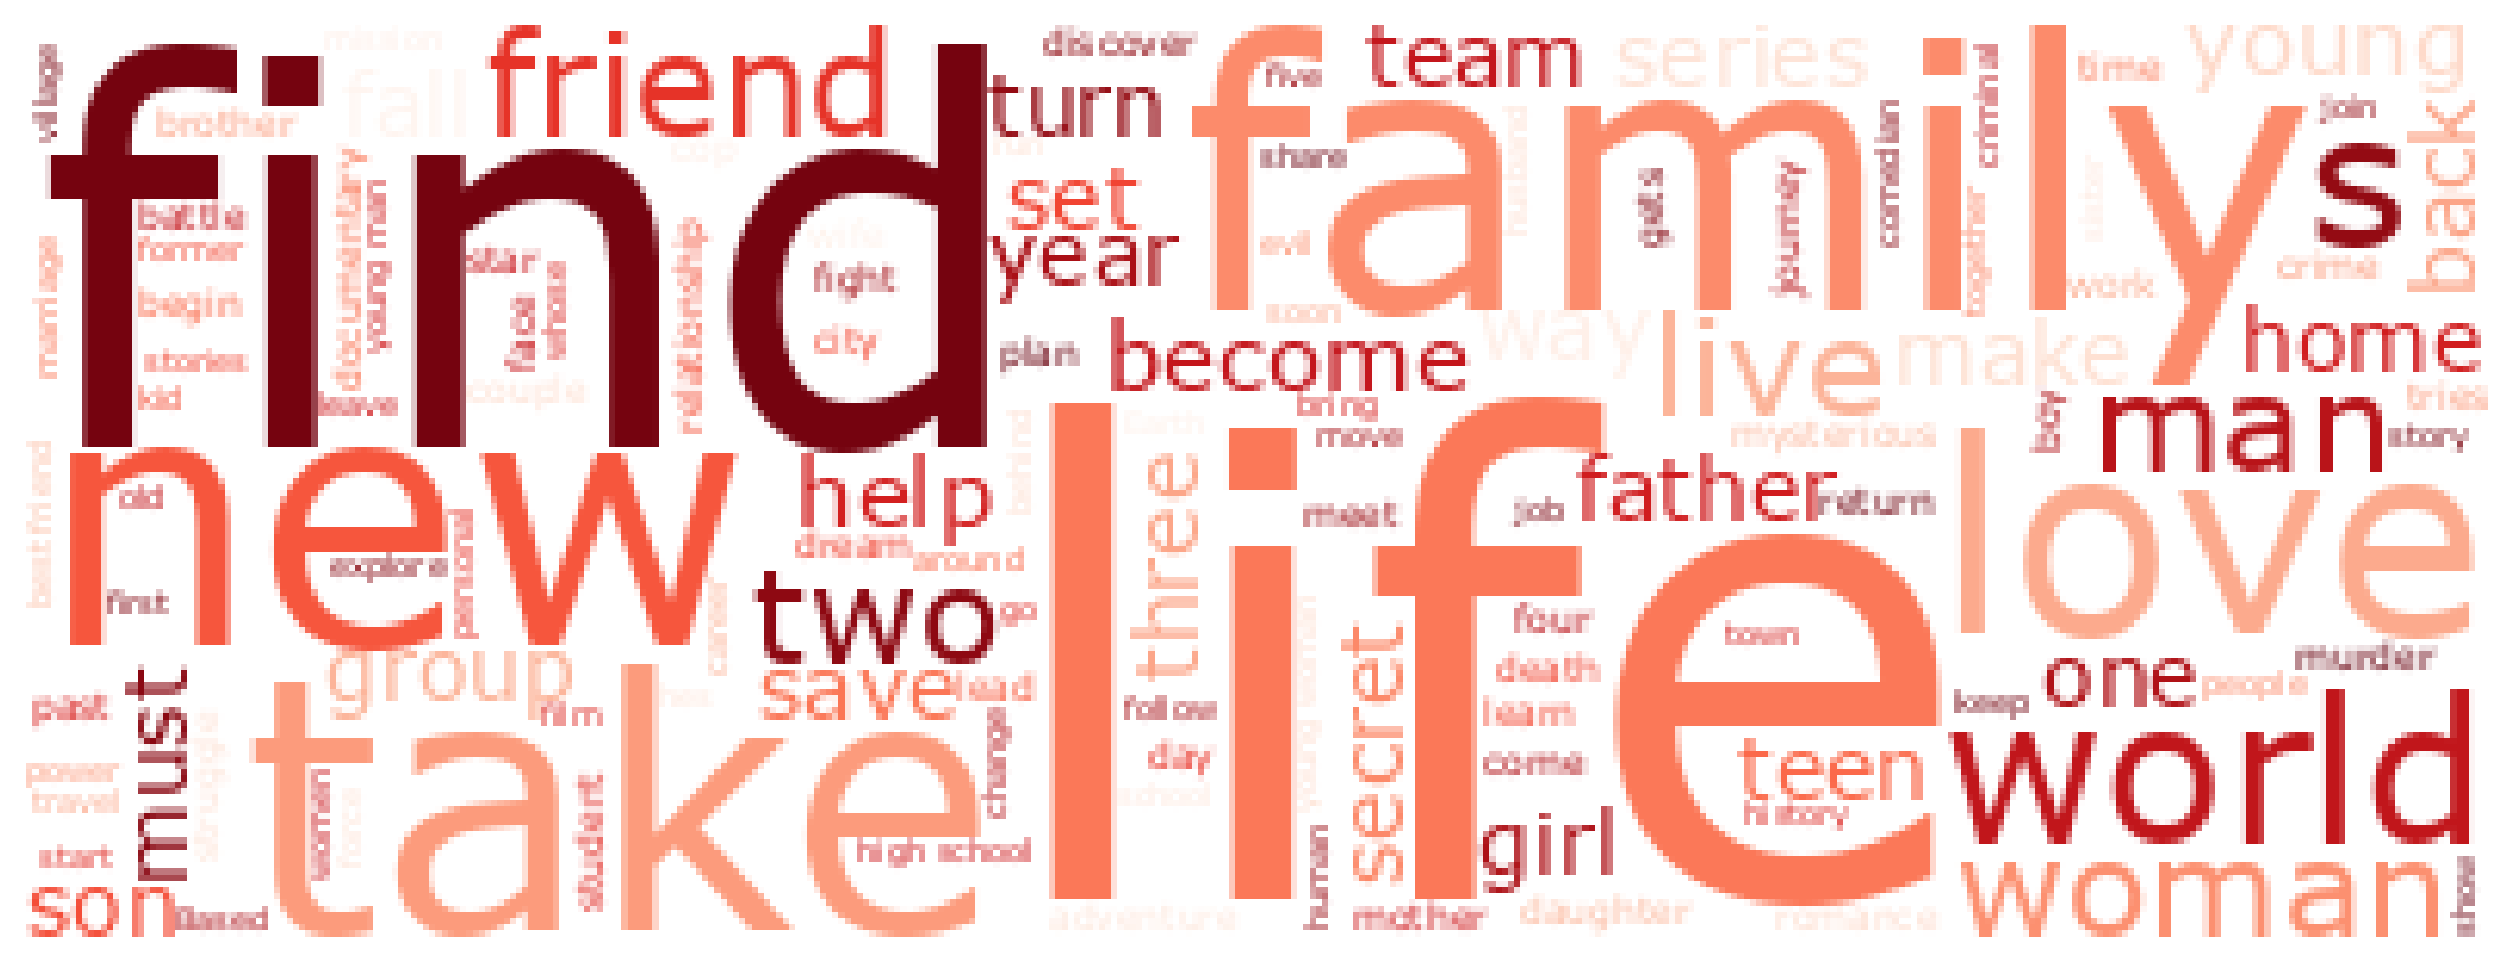

In [54]:
description = netflix["description"].tolist()
description =str(description)
description = re.sub("[\"\-\[\]\'\.\?]", "", description)
description = description.replace(" ", ",")
description = re.sub(",{2,}", ",", description)
wordcloud(description, width=400, height=150)

Looking at the wordcloud of Netflix content descriptions above, the words "find", "life" and "family" seem to be the most frequent words in the content descriptions. The words "world", "new", "take", "love" and "live" also frequently appear.

# 5. Conclusions

Netflix has made streaming available to a wide audience through investments in global content. 
Netflix is becoming more and more popular among various age groups and countries, and it is important to acknowledge the impact of this streaming platform on the global entertainment market. 


Here’s a summary of my analysis.
1. The majority content type on Netflix is movie.
2. Netflix started gaining traction after 2014. Since then, the amount of content added has been increasing significantly.
3. The country that produces the most amount of content is the United States, a home of Hollywood.
4. For movies, Netflix invests more in contents from the United States and India, while for TV shows, invests more in contents from East Asian countries.
5. Most contents on Netflix target more on adult age group of audience.
6. For movies, Netflix tends to promote from old classic contents to newly released, while for TV shows, focuses more on the contents made in recent years.
7. The most common genres on Netflix are International, Dramas and Comedies.